In [1]:
from IPython.display import HTML, display, Image

import warnings
warnings.filterwarnings('ignore')

# Probeset selection with Spapros

In this tutorial we showcase how to select a gene set with Spapros.    
   
Here we use the default settings only. Check out the [advanced selection tutorial](https://spapros.readthedocs.io/en/latest/tutorials/spapros_tutorial_advanced_selection.html) for adjustments for specific use cases. There we also cover the end-to-end probe set selection which includes probe design and constraints.

## Import packages

In [20]:
import scanpy as sc
import spapros as sp

In [21]:
sc.settings.verbosity = 0
sc.logging.print_header()
print(f"spapros=={sp.__version__}")

scanpy==1.8.2 anndata==0.8.0 umap==0.5.2 numpy==1.21.5 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6
spapros==0.1.0


## Load and preprocess data

For Spapros selections the count data should be log-normalised. Notably genes should not be scaled to mean=0 and std=1. We pre-select a given number of highly variable genes, here 1000. In real world applications we typically go for 8000.   
    
The example data set that we use here has a raw version and a processed version with scaled counts. To get log normalised counts we use the raw version. Cell and gene filters, cell type annotations, and the umap embedding we get from the processed version.

In [22]:
adata = sc.datasets.pbmc3k()
adata_tmp = sc.datasets.pbmc3k_processed()

# Get infos from the processed dataset
adata = adata[adata_tmp.obs_names,adata_tmp.var_names]
adata.obs['celltype'] = adata_tmp.obs['louvain']
adata.obsm['X_umap'] = adata_tmp.obsm['X_umap']
del adata_tmp

# Preprocess counts and get highly variable genes
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata,flavor="cell_ranger",n_top_genes=1000)

adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'celltype'
    var: 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_umap'

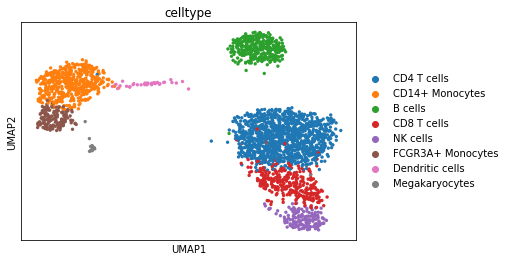

In [23]:
sc.pl.umap(adata,color="celltype")

## Run selection
First we create an instance of the `ProbesetSelector` class. We specify the number of genes `n` and the key in `adata.obs` where we find the cell type annotations (`celltype_key="celltype"`). Note that you can specify a `save_dir` to save results during selection and reload them next time a `ProbesetSelector` with the given `save_dir` is instantiated.

In [24]:
selector = sp.se.ProbesetSelector(adata, n=20, celltype_key="celltype", verbosity=1, save_dir=None)

The following celltypes' test set sizes for forest training are below min_test_n (=20):
	 Dendritic cells : 9
	 Megakaryocytes  : 3


Run the central method for probe set selection. (Takes ~5 min for the given example)

In [25]:
selector.select_probeset()


SPAPROS PROBESET SELECTION:                                                                  
Select pca genes.......................................... ━━━━━━━━━━━━━━━━━━━━  100% 0:00:00
Train baseline forest based on DE genes................... ━━━━━━━━━━━━━━━━━━━━   4/4 0:03:07
  Select DE genes......................................... ━━━━━━━━━━━━━━━━━━━━   8/8 0:00:00
  Train prior forest for DE_baseline forest............... ━━━━━━━━━━━━━━━━━━━━   3/3 0:00:44
  Iteratively add DE genes to DE_baseline forest.......... ━━━━━━━━━━━━━━━━━━━━   3/3 0:01:34
  Train final baseline trees on all celltypes............. ━━━━━━━━━━━━━━━━━━━━   3/3 0:00:47
Train final forests....................................... ━━━━━━━━━━━━━╺━━━━━━   2/3 0:01:21
  Train forest on pre/prior/pca selected genes............ ━━━━━━━━━━━━━━━━━━━━   3/3 0:00:46
  Iteratively add genes from DE_baseline_forest........... ━━━━━━━━━━━━━━━━━━━━ 12/12 0:00:35
  Train final trees on all celltypes...................... ━━━━━━━━━━━━━━━━━━━━   0/3 0:00:00

The selected probeset can be examined like this:   
(See [here](TODO: add link to some docstring or documentation that describes the output table) for a detailed description of the output table)

In [26]:
selector.probeset

,gene_nr,selection,rank,marker_rank,tree_rank,importance_score,pca_score,pre_selected,prior_selected,pca_selected,celltypes_DE_1vsall,celltypes_DE_specific,celltypes_DE,celltypes_marker,list_only_ct_marker,required_marker,required_list_marker
PF4,1,True,1.0,1.0,1.0,1.000000,0.810399,False,False,True,Megakaryocytes,,Megakaryocytes,Megakaryocytes,False,True,False
HLA-DPB1,2,True,1.0,1.0,1.0,0.649235,1.997253,False,False,True,"B cells,Dendritic cells",,"B cells,Dendritic cells","B cells,Dendritic cells",False,True,False
FCGR3A,3,True,1.0,1.0,1.0,0.612390,1.321373,False,False,True,,FCGR3A+ Monocytes,FCGR3A+ Monocytes,FCGR3A+ Monocytes,False,True,False
GZMB,4,True,1.0,1.0,1.0,0.512924,1.252898,False,False,True,NK cells,,NK cells,NK cells,False,True,False
CCL5,5,True,1.0,1.0,1.0,0.478418,2.553322,False,False,True,CD8 T cells,,CD8 T cells,CD8 T cells,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ARHGAP19,996,False,NaN,NaN,NaN,NaN,0.016906,False,False,False,,,,,False,False,False
SLC22A4,997,False,NaN,NaN,NaN,NaN,0.016718,False,False,False,,,,,False,False,False
DRAXIN,998,False,NaN,NaN,NaN,NaN,0.016547,False,False,False,,,,,False,False,False
C1QC,999,False,NaN,NaN,NaN,NaN,0.014339,False,False,False,,,,,False,False,False


The list of selected genes can be retrieved with

In [7]:
selector.probeset.index[selector.probeset.selection]

Index(['PF4', 'HLA-DQA1', 'GZMB', 'HLA-DPB1', 'S100A8', 'CCL5', 'LTB', 'AIF1',
       'CD79A', 'GZMK', 'GNLY', 'LST1', 'IL32', 'FCN1', 'NKG7', 'TYROBP',
       'LGALS2', 'CST3', 'GZMH', 'HLA-DPA1'],
      dtype='object')

## Vizualize and investigate the results

Let's first plot the mean expression in each cell type cluster with some additional information for the selected genes.

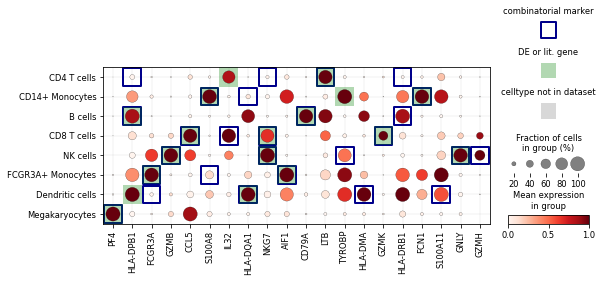

In [27]:
sp.pl.masked_dotplot(adata, selector)

For each cell type the combinatorial markers are those that build a combinatorial rule to classify the cell type. Often you find cell type specific markers, and negative markers. When selecting genes for high numbers of cell types including similar clusters the rules tend to show more sophisticated combinatorics.

The Spapros selection procedure consists of multiple steps, we can also investigate how many genes originate from the different steps:

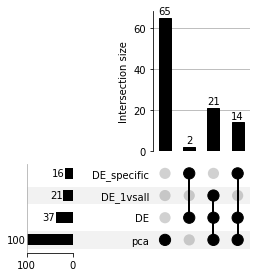

In [28]:
selector.plot_gene_overlap()

- X genes come from the PCA-based pre-selection which selects genes that capture a high amount of variation
- they strongly overlap with the differentially expressed genes since marker genes are one source of high variation in transcriptomics data. The overlap is especially high for datasets with only a few cell type clusters that are also well separated as in the given example.
- The first DE tests to train optimal classification trees are tests between each cell type and all other cell types as background (DE_1vsall). To further optimise the trees we run DE tests between cell type clusters that are more difficult to distinguish (DE_specific). We find Y genes that originate from the specific tests that didn't occur in the 1 vs all tests.

## What's next?

Now you should evaluate the selected probeset. See our [basic evaluation tutorial](https://spapros.readthedocs.io/en/latest/tutorials/spapros_tutorial_basic_evaluation.html).

If you want to customize and improve the probeset selection, have a look at the [advanced selection tutorial](https://spapros.readthedocs.io/en/latest/tutorials/spapros_tutorial_advanced_selection.html).